# Abstract
We will be looking at the instantaneous change of the price of the above asset. Big changes in the asset price will be interpreted as buy/sell signals. The definition of "big change" will be optimized for profit.

1. Track and smooth the instantaneous change (data-points are one minute apart, so we will take a rolling average of the minute-by-minute % change)
2. Normalize the smoothed values
3. Take buy and sell signals based on a threshold. Whenever the rolling-avg % change in price changes by more than x standard deviations, buy.
4. We will also set a "take-profit" threshold. Rather than wait exclusively for sell signals, we will also take profits whenever the opportunity arises.

In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('prices.pickle', 'rb') as pik:
    df = pd.DataFrame(pickle.load(pik))
df.head()

,time,bid,ask
0,2021-01-19 19:43:03.726986,159.54000000,159.70000000
1,2021-01-19 19:44:03.962890,159.50000000,159.56000000
2,2021-01-19 19:45:04.197403,159.13000000,159.42000000
3,2021-01-19 19:46:04.519433,159.26000000,159.48000000
4,2021-01-19 19:47:04.687331,159.37000000,159.47000000


In [3]:
# Define global variables
window = 100
profitThreshold = 1.002
stdThreshold = 2.75

<AxesSubplot:xlabel='time'>

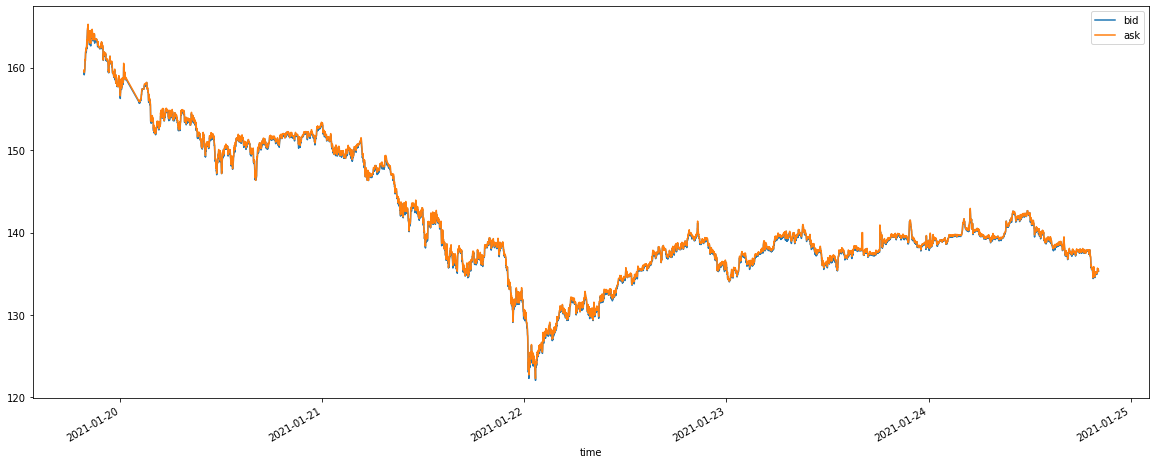

In [4]:
# Take a look at the data
df.set_index('time', inplace=True)
df[['bid', 'ask']] = df[['bid', 'ask']].astype(float)
df[['bid', 'ask']].plot(figsize = (20,8))

<AxesSubplot:xlabel='time'>

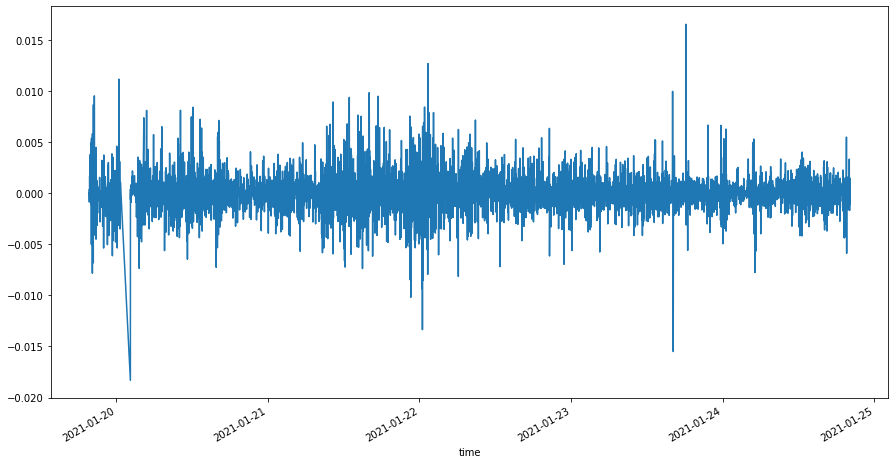

In [5]:
# # Find instantaneous price changes
def change(lst):
    out = [0]
    before = lst[0]
    for i in lst[1:]:
        theChange = (i - before) / before
        out.append(theChange)
        before = i
    return out
df['pctChange'] = change(list(df['ask']))
df['pctChange'].plot(figsize=(15,8))

<AxesSubplot:xlabel='time'>

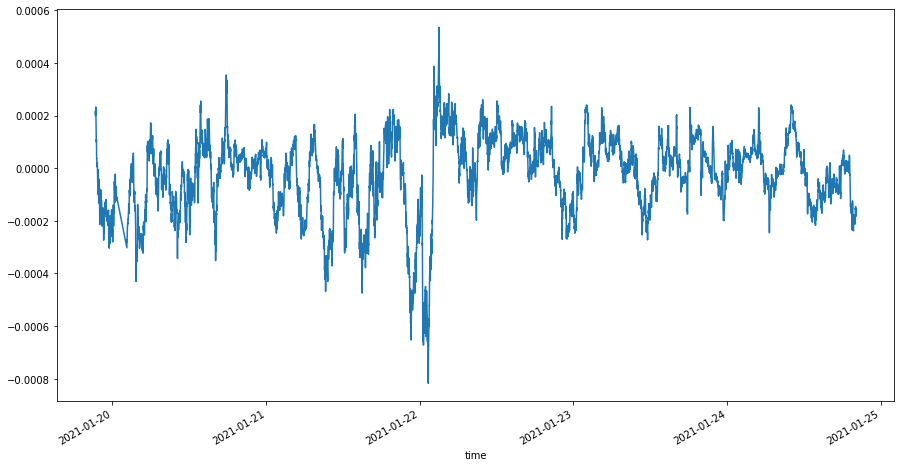

In [6]:
# Smooth the values
df['smoothedChange'] = df['pctChange'].rolling(window).mean()
df['smoothedChange'].plot(figsize=(15,8))

## Normalizing 
Now we need to normalize these values - we will need a running average (of the rolling average) and a running standard deviation (also of the rolling average)

In [7]:
# Drop the nans we created when we smoothed our values
df = df.dropna()

# Compute running avg
total = 0
count = 0
avgs = []
for index, row in df.iterrows():
    total += row['smoothedChange']
    count += 1
    avgs.append(total / count)

df['runningAvg'] = avgs
df.head()

,bid,ask,pctChange,smoothedChange,runningAvg
time,,,,,
2021-01-19 21:18:38.986526,163.05,163.11,-0.000184,0.000215,0.000215
2021-01-19 21:19:39.087337,162.90,163.05,-0.000368,0.000211,0.000213
2021-01-19 21:20:39.270452,162.53,162.73,-0.001963,0.000200,0.000209
2021-01-19 21:21:39.408348,162.56,162.70,-0.000184,0.000207,0.000208
2021-01-19 21:22:39.521769,162.84,162.95,0.001537,0.000219,0.000211


In [8]:
# Compute running stdev
deviations = []
for i in range(1, df.shape[0] + 1):
    std = df.iloc[:i]['smoothedChange'].std()
    deviations.append(std)
df['runningStdev'] = deviations
df = df.dropna()
df.head()

,bid,ask,pctChange,smoothedChange,runningAvg,runningStdev
time,,,,,,
2021-01-19 21:19:39.087337,162.90,163.05,-0.000368,0.000211,0.000213,0.000003
2021-01-19 21:20:39.270452,162.53,162.73,-0.001963,0.000200,0.000209,0.000008
2021-01-19 21:21:39.408348,162.56,162.70,-0.000184,0.000207,0.000208,0.000006
2021-01-19 21:22:39.521769,162.84,162.95,0.001537,0.000219,0.000211,0.000007
2021-01-19 21:23:39.627399,162.99,163.16,0.001289,0.000232,0.000214,0.000011


<AxesSubplot:xlabel='time'>

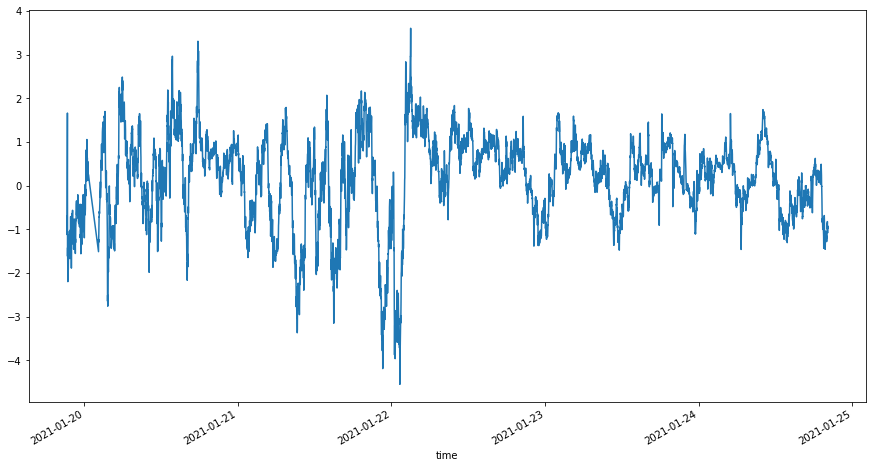

In [9]:
df['normalized'] = (np.array(df['smoothedChange']) - np.array(df['runningAvg'])) / np.array(df['runningStdev'])
df['normalized'].plot(figsize = (15,8))

## Deviation threshold
Okay, we now have our normalized rolling %-change values! Let's visualize what it looks like to set the threshold outlined in the Abstract

<AxesSubplot:xlabel='time'>

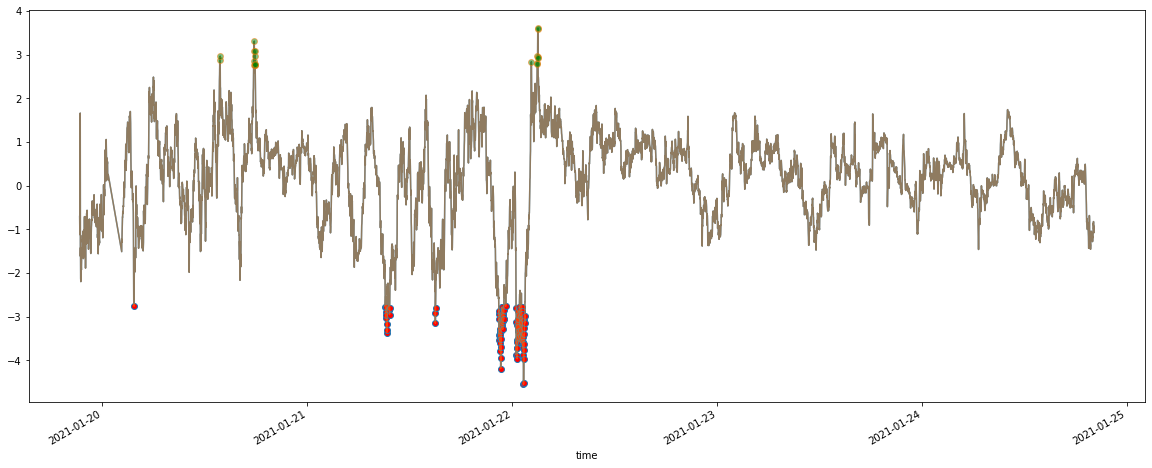

In [10]:

df['buy'] = df['normalized'] < -stdThreshold
df['sell'] = df['normalized'] > stdThreshold
df['normalized'].plot(marker = 'o', markerfacecolor = 'r', markevery = list(df['buy']), figsize = (20,8))
df['normalized'].plot(marker = 'o', markerfacecolor = 'g', markevery = list(df['sell']), figsize = (20,8), alpha = .5)


### Now what does that look like on the actual price data?

<AxesSubplot:xlabel='time'>

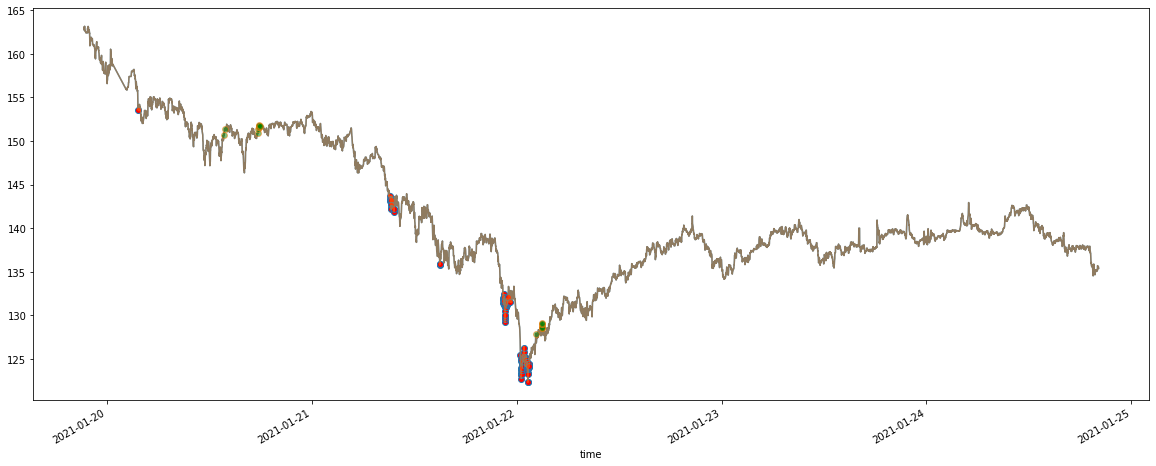

In [11]:
df['ask'].plot(marker = 'o', markerfacecolor = 'r', markevery = list(df['buy']), figsize = (20,8))
df['ask'].plot(marker = 'o', markerfacecolor = 'g', markevery = list(df['sell']), figsize = (20,8), alpha = .5)

## Simulation
Now we need to loop over the dataset and buy and sell according to the above indicators

<AxesSubplot:xlabel='time'>

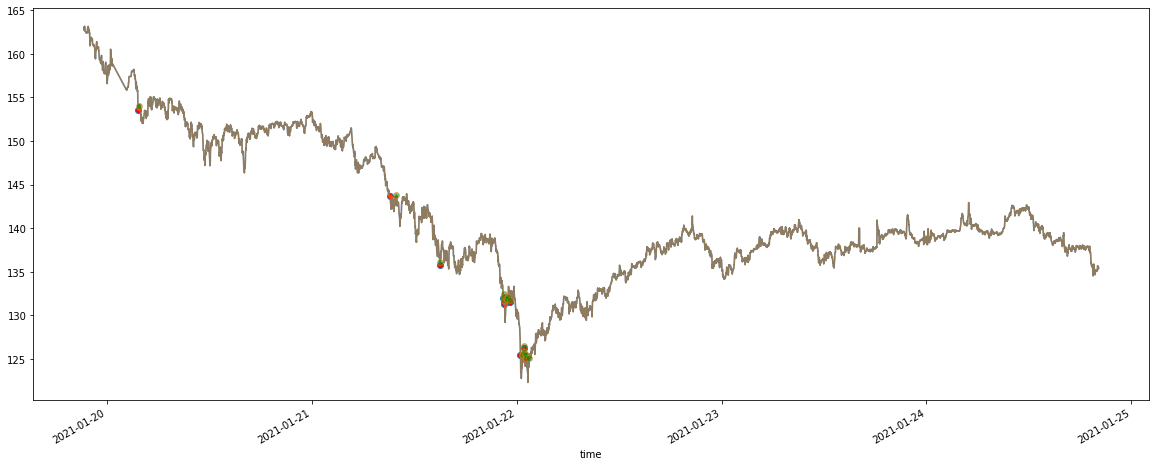

In [12]:
# Define initial position
usd = 500
xmr = 0
holding = False 
tradeCount = 0

#Containers to visualize our actions
bought = []
sold = []
trades = []

for index, row in df.iterrows():
    if not holding and row['buy']: 
        # If we aren't holding xmr and we also see a buy signal, Buy!
        tradeCount += 1
        entryPrice = row['bid']
        cost = usd
        xmr = (usd / entryPrice) * (1- .0026) #<- fee
        usd = 0
        holding = True
        
        # Prepare visualization
        bought.append(True)
        sold.append(False)
        trade = f'Bought {xmr} xmr for {cost}'
        trades.append(trade)
        continue
    elif holding and (row['sell'] or row['ask'] >= entryPrice * profitThreshold): 
        #If we are holding xmr and we see a sell signal OR the minimum profit has been met, Sell!
        tradeCount += 1
        cost = xmr
        usd = (xmr * row['ask']) * (1- .0026) #<- fee
        xmr = 0
        holding = False
        
        # Prepare visualization
        bought.append(False)
        sold.append(True)
        trade = f'Sold {cost} xmr for {usd}'
        trades.append(trade)
        continue
    else:
        bought.append(False)
        sold.append(False)
        
df['bought'] = bought
df['sold'] = sold

df['ask'].plot(marker = 'o', markerfacecolor = 'r', markevery = list(df['bought']), figsize = (20,8))
df['ask'].plot(marker = 'o', markerfacecolor = 'g', markevery = list(df['sold']), alpha = .5, figsize = (20,8))


In [13]:
# View Profit
holdingProfit = df.iloc[-1]['ask'] / df.iloc[0]['ask']
if xmr == 0:
    print(f'Profit: {usd / 500}, TxCount: {tradeCount}')
else:
    print(f'Profit: {(xmr * df.iloc[-1]["ask"]) / 500}, TxCount: {tradeCount}')
for trade in trades:
    print(trade)
    

Profit: 0.9676798617414998, TxCount: 38
Bought 3.2539475401278875 xmr for 500
Sold 3.2539475401278875 xmr for 499.83749545739266
Bought 3.474616099590211 xmr for 499.83749545739266
Sold 3.474616099590211 xmr for 498.24673819082557
Bought 3.6618620342755093 xmr for 498.24673819082557
Sold 3.6618620342755093 xmr for 497.22973001316745
Bought 3.7585216575606912 xmr for 497.22973001316745
Sold 3.7585216575606912 xmr for 496.2594589756118
Bought 3.774357056445594 xmr for 496.2594589756118
Sold 3.774357056445594 xmr for 496.16686336342656
Bought 3.753616728752136 xmr for 496.16686336342656
Sold 3.753616728752136 xmr for 494.60099123975255
Bought 3.749164224521425 xmr for 494.60099123975255
Sold 3.749164224521425 xmr for 493.37859949112004
Bought 3.7416044337929066 xmr for 493.37859949112004
Sold 3.7416044337929066 xmr for 492.1971602301367
Bought 3.738614329552497 xmr for 492.1971602301367
Sold 3.738614329552497 xmr for 491.6546649731828
Bought 3.724283153673977 xmr for 491.6546649731828
Sol

Now, we can plug and play with different values.

Is it more profitable to smooth our %-change values over a short period, or a long one?

Is it more profitable to look at price swings of 2 standard deviations, 3, or 4?

When taking profits, is it better to be conservative, or greedy?

We can optimize this heuristically. Because this task is highly iterative, we will switch over to c++!